# Aprendizaje Automatico
##TP 1 - Regresion

### Importacion de librerias

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import holidays

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)
#df.shape

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


##Limpieza de la variable target

Analizamos la variable target (fare_amount). Eliminamos los valores fisicamente imposibles.

count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64


<Axes: >

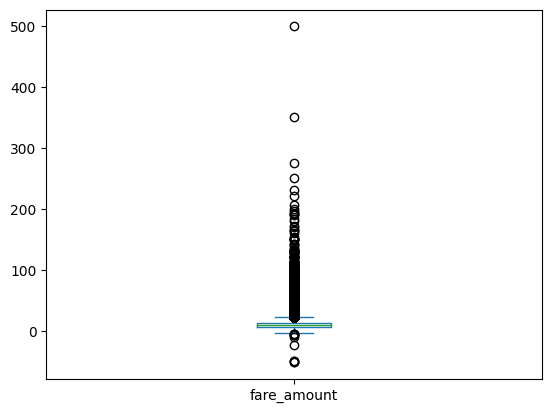

In [4]:
#Informacion de la variable target
print(df['fare_amount'].describe())
df['fare_amount'].plot(kind='box')

In [5]:
#Eliminamos registros con costo de viaje fisicamente imposible (<=0 o que tengan valor NaN)
df.drop(df[(df['fare_amount'] <= 0) | (df['fare_amount'].isna()) ].index, inplace=True)


##Variables relacionadas con fechas

El dataset cuenta con dos variables de tipo fecha. Ambas cuentan con la misma informacion, ninguna aporta algo distinto a la otra. Se decide eliminar una de ellas y cambiar el tipo de datos de la restante. Luego se crean las variables dummies que surgen a partir de ella:

*   fin_de_semana: indica si el viaje ocurrió durante el fin de semana (se considera fin de semana los dias jueves, viernes, sabado y domingo)
*   hora_manana: indica si el viaje ocurrió entre las 6 y las 11 hs
*   hora_tarde: indica si el viaje ocurrió entre las 12 y las 17 hs
*   hora_noche: indica si el viaje ocurrió entre las 18 y las 23 hs
*   hora_madrugada: indica si el viaje ocurrió entre las 00 y las 5 hs
*   es_feriadoÑ indica si el viaje ocurrió un dia feriado


In [6]:
#Cambiamos tipo de dato de la fecha del viaje
df['date_c'] = pd.to_datetime(df['date'], errors='coerce').dt.round('s')

#Eliminamos pickup_datetime ya que es igual a la variable date
df = df.drop('pickup_datetime', axis=1)
print(df['date_c'].describe())

count                  199978
unique                 196607
top       2010-03-14 12:00:00
freq                        4
first     2009-01-01 01:15:22
last      2015-06-30 23:40:39
Name: date_c, dtype: object


C:\Users\Agustin\AppData\Local\Temp\ipykernel_17004\2633672156.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df['date_c'].describe())


In [7]:
#fin_de_semana = Jue, Vier, Sab, Dom
df['fin_de_semana']=df['date_c'].dt.dayofweek.apply(lambda x: True if 3 <= x <= 6 else False)

df['hora']=df['date_c'].dt.hour
df['hora_manana'] = df['hora'].apply(lambda x: True if 6 <= x <= 11 else False)
df['hora_tarde'] = df['hora'].apply(lambda x: True if 12 <= x <= 17 else False)
df['hora_noche'] = df['hora'].apply(lambda x: True if 18 <= x <= 23 else False)
df['hora_madrugada'] = df['hora'].apply(lambda x: True if 0 <= x <= 5 else False)



In [8]:
#Creamos variable para saber si el viaje se realizo un dia feriado
min_anio = min(df['date_c'].dt.year)
max_anio = max(df['date_c'].dt.year)
feriados = holidays.CountryHoliday('US',years=range(min_anio, max_anio + 1))
df['es_feriado'] = df['date_c'].dt.date.isin(feriados)

##Variables en relacion a cantidad de pasajeros

El dataset cuenta con una variable que indica la cantidad de pasajeros que tuvo el viaje. Se limpia la variable para valores fisicamente imposibles. A partir de ella se decide crear las siguientes variables dummies:

*   mensajeria: indica si el viaje no tuvo pasajeros (viaje tipo delivery)
*   uber_xl: indica si el vehiculo utilizado es de gran capacidad (igual o mayor a 5 pasajeros)



In [9]:
#Observamos valores de las varaibles
print(df['passenger_count'].unique())

#Seteamos en NaN un registro que es outlier
df.loc[df['passenger_count'] == 208,'passenger_count'] = np.nan

#Creamos variables en funcion a la cantidad de pasajeros
df['mensajeria'] = df['passenger_count'].apply(lambda x: True if x == 0 else False)
df['uber_xl'] =  df['passenger_count'].apply(lambda x: True if x >= 5 else False)

[  1   3   5   2   4   6   0 208]


##Variables en relacion a los puntos de inicio y fin del viaje

El dataset cuenta con 4 columnas que indican el punto de coordenadas de inicio y fin del viaje. Analizando el dataset se puede observar que los viajes son principalmente en la ciudad de New York (USA). En funcion a ello, se decide limpiar todos los puntos de inicio y fin de viaje que se encuentran por fuera de los limites de EEUU.

A partir de las cuatro columnas se decide crear una variable llamada distancia_viaje_km que indica la distancia en kilometros del punto de inicio al punto de fin. Se decide limpiar las distancias iguales a 0km.

In [10]:
#Graficamos los puntos para observan donde se concentran los viajes del dataset
fig = px.scatter_mapbox(df, lat="pickup_latitude", lon="pickup_longitude", zoom=8, mapbox_style="open-street-map")
fig.update_layout(mapbox_center={"lat": 40.748, "lon": -73.985}, margin=dict(l=0, r=0, t=0, b=0))
fig.show()

C:\Users\Agustin\AppData\Local\Temp\ipykernel_17004\4108287342.py:2: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(df, lat="pickup_latitude", lon="pickup_longitude", zoom=8, mapbox_style="open-street-map")


In [11]:
#Detectamos registros que fisicamente tienen punto de inicio y fin dentro del territorio de EEUU
df_keys_usa = df[
    (df['pickup_latitude'] >= 24) & (df['pickup_latitude'] <= 49) &
    (df['pickup_longitude'] >= -125) & (df['pickup_longitude'] <= -67) &
    (df['dropoff_latitude'] >= 24) & (df['dropoff_latitude'] <= 49) &
    (df['dropoff_longitude'] >= -125) & (df['dropoff_longitude'] <= -67) &
    #(df['pickup_latitude'] >= 40) & (df['pickup_latitude'] <= 46) &
    #(df['pickup_longitude'] >= -80) & (df['pickup_longitude'] <= -70) &
    #(df['dropoff_latitude'] >= 40) & (df['dropoff_latitude'] <= 46) &
    #(df['dropoff_longitude'] >= -80) & (df['dropoff_longitude'] <= -70) &
    (df['pickup_latitude'].isna() == False) &
    (df['pickup_longitude'].isna() == False) &
    (df['dropoff_latitude'].isna() == False) &
    (df['dropoff_longitude'].isna() == False)
]['key']

columnas_grados = ['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']
columnas_rad = ['pickup_longitude_rad', 'dropoff_longitude_rad', 'pickup_latitude_rad', 'dropoff_latitude_rad']

#Seteamos en nan columnas en radianes
df[columnas_rad] = np.nan

#Calculamos coordenadas en radianes
df.loc[df['key'].isin(df_keys_usa),'pickup_longitude_rad']  = np.radians(df.loc[df['key'].isin(df_keys_usa),'pickup_longitude' ])
df.loc[df['key'].isin(df_keys_usa),'dropoff_longitude_rad'] = np.radians(df.loc[df['key'].isin(df_keys_usa),'dropoff_longitude' ])
df.loc[df['key'].isin(df_keys_usa),'pickup_latitude_rad']   = np.radians(df.loc[df['key'].isin(df_keys_usa),'pickup_latitude' ])
df.loc[df['key'].isin(df_keys_usa),'dropoff_latitude_rad']  = np.radians(df.loc[df['key'].isin(df_keys_usa),'dropoff_latitude' ])

# Radio de la tierra en km
R = 6371

dif_lat = df['dropoff_latitude_rad'] - df['pickup_latitude_rad']
dif_lon = df['dropoff_longitude_rad'] - df['pickup_longitude_rad']

# Formula de Haversine
a = np.sin(dif_lat / 2)**2 + np.cos(df['pickup_latitude_rad']) * np.cos(df['dropoff_latitude_rad']) * np.sin(dif_lon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

#Distancia del viaje en KM
df['distancia_viaje_km'] = R * c

#Limpio distacias en 0 ya que son fisicamente imposibles
df.loc[df['distancia_viaje_km'] == 0 ,'distancia_viaje_km'] = np.nan

##Dividimos dataset para calcular modelos

Se divide el dataset para poder entrenar y testear los modelos.

In [12]:
#Dividimos dataset en conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

#df_train = X_train.join(y_train)

##Imputacion de valores

Se imputan los valores de las siguientes variables:
*   passenger_count: se utiliza la mediana
*   distancia_viaje_km: se utiliza la mediana

Dada la gran cantidad de valores atípicos, se decide limpiar e imputar con la mediana aquellos valores de distancia_viaje_km que se encuentren por debajo o por encima de 1.5 veces el rango intercuartílico.

In [13]:
#Imputamos variables y recalculamos variables ajustamos variables en Xtrain y Xtest
X_train.loc[ X_train['passenger_count'].isna(),'passenger_count']  = X_train['passenger_count'].median()
X_train['mensajeria'] = X_train['passenger_count'].apply(lambda x: True if x == 0 else False)
X_train['uber_xl'] =  X_train['passenger_count'].apply(lambda x: True if x >= 5 else False)


X_test.loc[ X_test['passenger_count'].isna(),'passenger_count']  = X_test['passenger_count'].median()
X_test['mensajeria'] = X_test['passenger_count'].apply(lambda x: True if x == 0 else False)
X_test['uber_xl'] =  X_test['passenger_count'].apply(lambda x: True if x >= 5 else False)


X_val.loc[ X_val['passenger_count'].isna(),'passenger_count']  = X_val['passenger_count'].median()
X_val['mensajeria'] = X_val['passenger_count'].apply(lambda x: True if x == 0 else False)
X_val['uber_xl'] =  X_val['passenger_count'].apply(lambda x: True if x >= 5 else False)


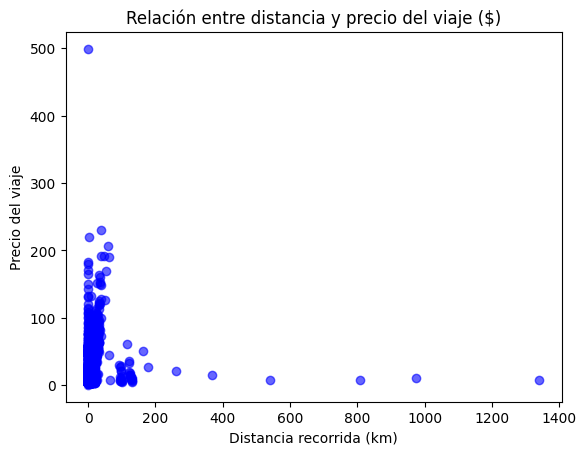

In [14]:
x = X_train['distancia_viaje_km']
y = y_train

plt.scatter(x, y, color='blue', alpha=0.6)

plt.xlabel("Distancia recorrida (km)")
plt.ylabel("Precio del viaje")
plt.title("Relación entre distancia y precio del viaje ($)")


plt.show()

In [15]:
# Calcular cuartiles y rango intercuartílico
Q1 = X_train["distancia_viaje_km"].quantile(0.25)  # Primer cuartil (Q1)
Q3 = X_train["distancia_viaje_km"].quantile(0.75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1  # Rango intercuartílico

# Definir límites de valores aceptables
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#print(lower_bound,upper_bound)
#print(df_train[df_train["distancia_viaje_km"]>upper_bound].shape)

X_train.loc[(X_train["distancia_viaje_km"] < lower_bound) | (X_train["distancia_viaje_km"] > upper_bound), ["distancia_viaje_km"]] = np.nan
X_train.loc[ X_train['distancia_viaje_km'].isna(),'distancia_viaje_km']  = X_train['distancia_viaje_km'].median()

In [16]:
# Calcular cuartiles y rango intercuartílico
Q1 = X_test["distancia_viaje_km"].quantile(0.25)  # Primer cuartil (Q1)
Q3 = X_test["distancia_viaje_km"].quantile(0.75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1  # Rango intercuartílico

# Definir límites de valores aceptables
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#print(lower_bound,upper_bound)
#print(df_train[df_train["distancia_viaje_km"]>upper_bound].shape)

X_test.loc[(X_test["distancia_viaje_km"] < lower_bound) | (X_test["distancia_viaje_km"] > upper_bound), ["distancia_viaje_km"]] = np.nan
X_test.loc[ X_test['distancia_viaje_km'].isna(),'distancia_viaje_km']  = X_test['distancia_viaje_km'].median()

In [17]:
# Calcular cuartiles y rango intercuartílico
Q1 = X_val["distancia_viaje_km"].quantile(0.25)  # Primer cuartil (Q1)
Q3 = X_val["distancia_viaje_km"].quantile(0.75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1  # Rango intercuartílico

# Definir límites de valores aceptables
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#print(lower_bound,upper_bound)
#print(df_train[df_train["distancia_viaje_km"]>upper_bound].shape)

X_val.loc[(X_val["distancia_viaje_km"] < lower_bound) | (X_val["distancia_viaje_km"] > upper_bound), ["distancia_viaje_km"]] = np.nan
X_val.loc[ X_val['distancia_viaje_km'].isna(),'distancia_viaje_km']  = X_val['distancia_viaje_km'].median()

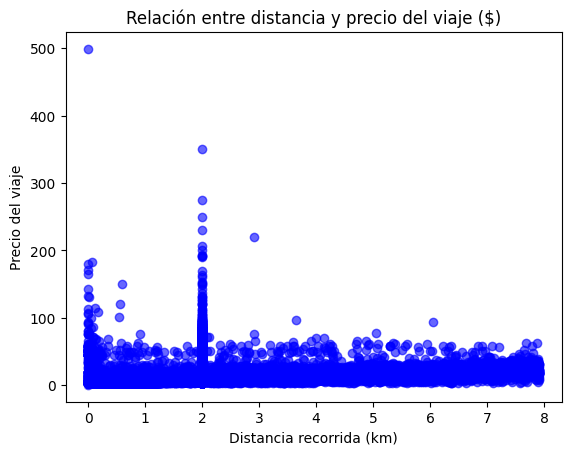

In [18]:
x = X_train['distancia_viaje_km']
y = y_train

plt.scatter(x, y, color='blue', alpha=0.6)

plt.xlabel("Distancia recorrida (km)")
plt.ylabel("Precio del viaje")
plt.title("Relación entre distancia y precio del viaje ($)")


plt.show()

##Escalado

Todas nuestras valiables son dummies excepto distancia_viaje_km. Se decide escalar dicha variable, utilizando el metodo MinMax, para que todas las variables del dataset tengan sus valores distribuidos entre el 0 y el 1.

In [19]:
#Escalamos distancia en un rango de 0 y 1 ya que todas nuestras variables restantes se encuentran en dicho intervalo
scaler_train = MinMaxScaler()
X_train[['distancia_viaje_km_escalada']] = scaler_train.fit_transform(X_train[['distancia_viaje_km']])

In [20]:
scaler_test = MinMaxScaler()
X_test[['distancia_viaje_km_escalada']] = scaler_test.fit_transform(X_test[['distancia_viaje_km']])

In [21]:
scaler_val = MinMaxScaler()
X_val[['distancia_viaje_km_escalada']] = scaler_val.fit_transform(X_val[['distancia_viaje_km']])

In [22]:
df_train = X_train.join(y_train)

##Graficos





             Mañana         Tarde         Noche     Madrugada
count  33725.000000  40050.000000  48027.000000  18182.000000
mean      11.106244     11.604629     10.980015     12.181487
std        9.727382     10.500627      9.141282     11.010568
min        2.500000      2.500000      0.110000      2.500000
25%        5.700000      6.000000      6.100000      6.100000
50%        8.100000      8.500000      8.500000      9.000000
75%       12.100000     12.500000     12.500000     14.500000
max      230.000000    220.000000    350.000000    499.000000


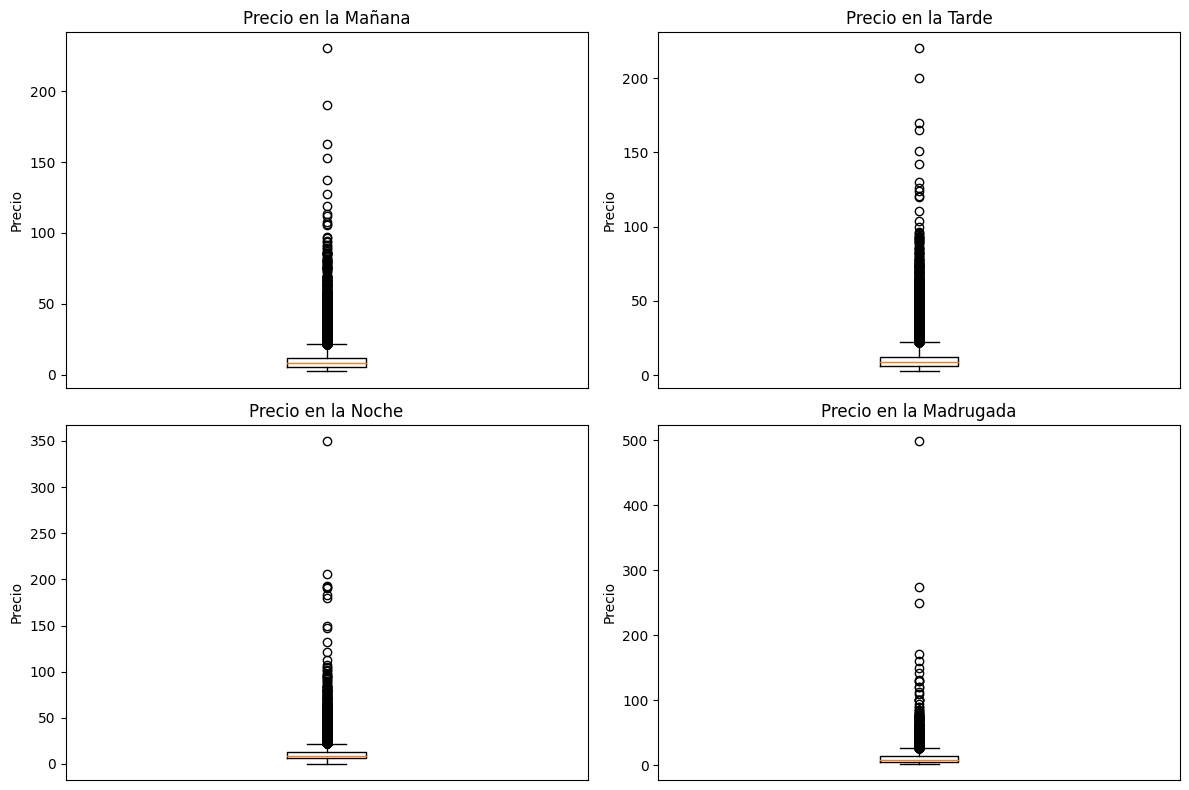

In [23]:
describe_manana = df_train[df_train['hora_manana']]['fare_amount'].describe()
describe_tarde = df_train[df_train['hora_tarde']]['fare_amount'].describe()
describe_noche = df_train[df_train['hora_noche']]['fare_amount'].describe()
describe_madrugada = df_train[df_train['hora_madrugada']]['fare_amount'].describe()

describe_df = pd.DataFrame({
    'Mañana': describe_manana,
    'Tarde': describe_tarde,
    'Noche': describe_noche,
    'Madrugada': describe_madrugada
})

print(describe_df)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].boxplot(df_train[df_train['hora_manana']]['fare_amount'])
axes[0, 0].set_title('Precio en la Mañana')
axes[0, 0].set_ylabel('Precio')
axes[0, 0].set_xticks([])


axes[0, 1].boxplot(df_train[df_train['hora_tarde']]['fare_amount'])
axes[0, 1].set_title('Precio en la Tarde')
axes[0, 1].set_ylabel('Precio')
axes[0, 1].set_xticks([])


axes[1, 0].boxplot(df_train[df_train['hora_noche']]['fare_amount'])
axes[1, 0].set_title('Precio en la Noche')
axes[1, 0].set_ylabel('Precio')
axes[1, 0].set_xticks([])


axes[1, 1].boxplot(df_train[df_train['hora_madrugada']]['fare_amount'])
axes[1, 1].set_title('Precio en la Madrugada')
axes[1, 1].set_ylabel('Precio')
axes[1, 1].set_xticks([])

plt.tight_layout()
plt.show()

       Fin de semana  Resto de semana
count   82329.000000     57655.000000
mean       11.415068        11.245396
std        10.108224         9.709320
min         0.110000         2.500000
25%         6.000000         6.000000
50%         8.500000         8.500000
75%        12.900000        12.500000
max       499.000000       192.330000


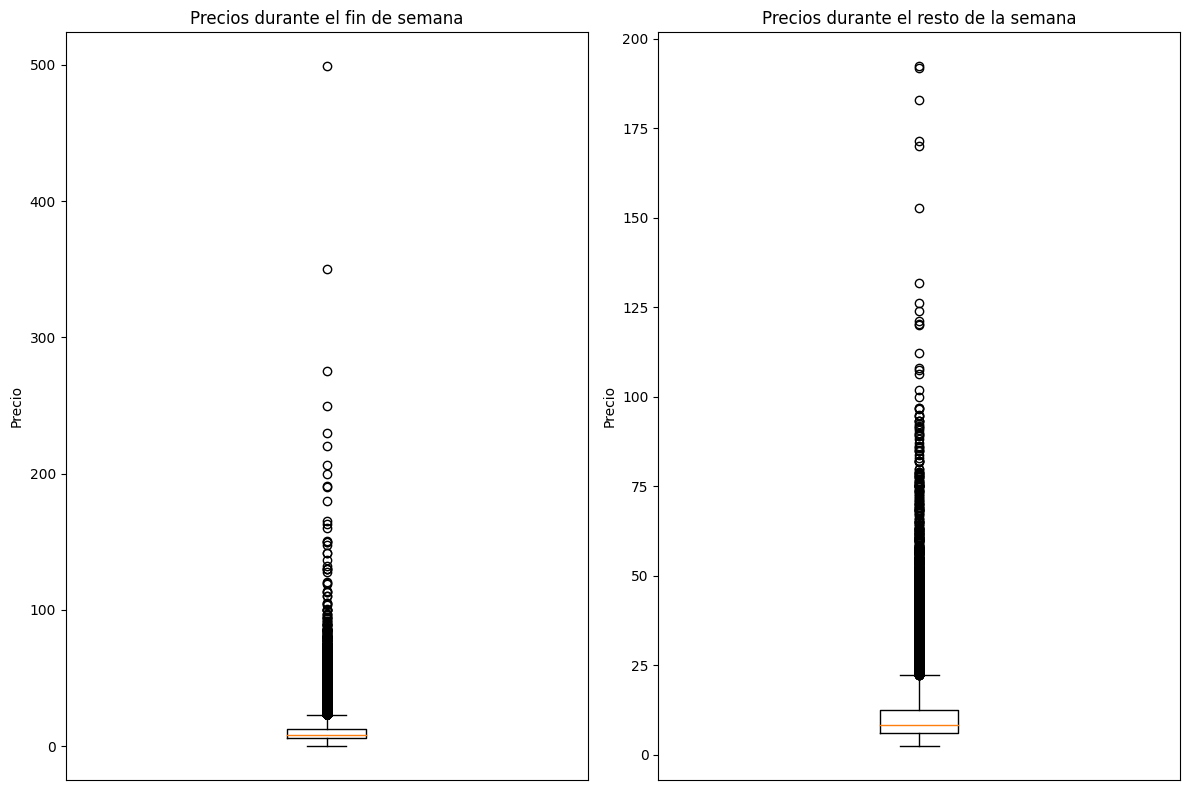

In [24]:
describe_finde = df_train[df_train['fin_de_semana']]['fare_amount'].describe()
describe_semana = df_train[~df_train['fin_de_semana']]['fare_amount'].describe()

describe_df = pd.DataFrame({
    'Fin de semana': describe_finde,
    'Resto de semana': describe_semana,
})

print(describe_df)


fig, axes = plt.subplots(1, 2, figsize=(12, 8))

axes[0].boxplot(df_train[df_train['fin_de_semana']]['fare_amount'])
axes[0].set_title('Precios durante el fin de semana')
axes[0].set_ylabel('Precio')
axes[0].set_xticks([])


axes[1].boxplot(df_train[~df_train['fin_de_semana']]['fare_amount'])
axes[1].set_title('Precios durante el resto de la semana')
axes[1].set_ylabel('Precio')
axes[1].set_xticks([])


plt.tight_layout()
plt.show()

          Feriados    No feriados
count  3184.000000  136800.000000
mean     11.452381      11.342691
std      10.194773       9.940346
min       2.500000       0.110000
25%       6.000000       6.000000
50%       8.500000       8.500000
75%      12.500000      12.500000
max     120.300000     499.000000


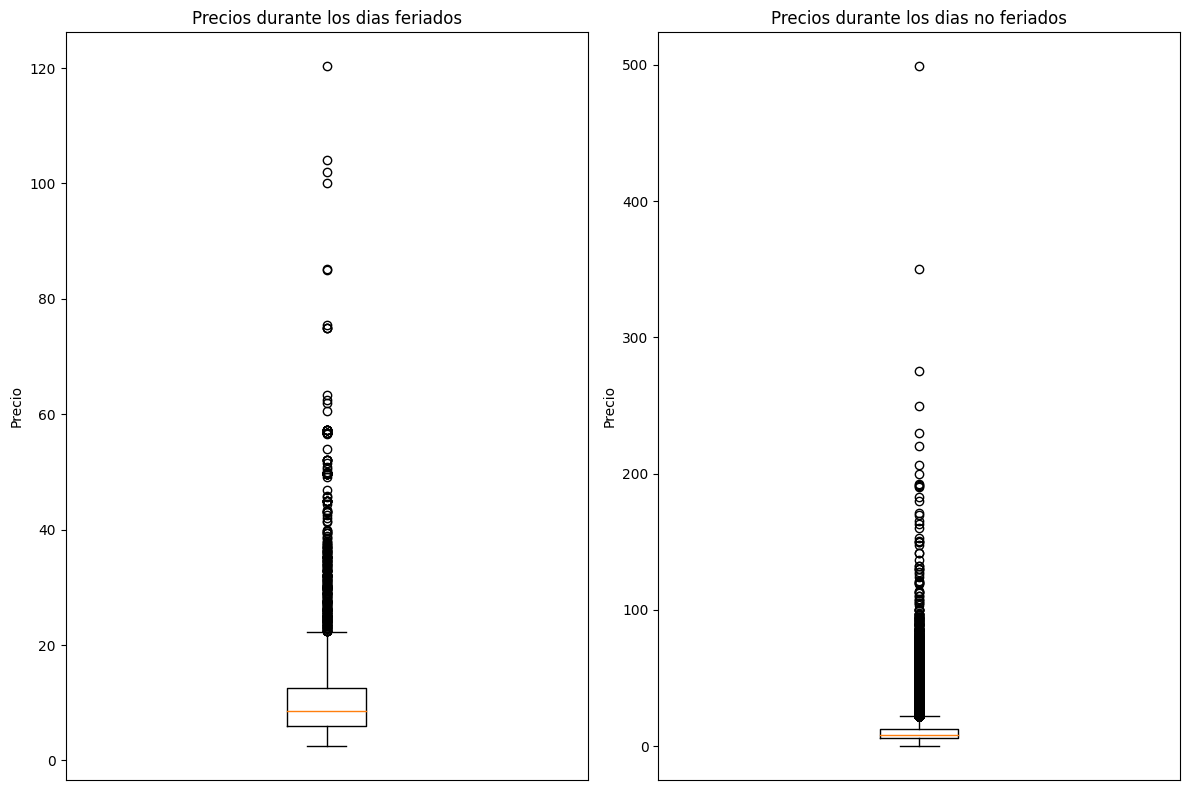

In [25]:
describe_feriado = df_train[df_train['es_feriado']]['fare_amount'].describe()
describe_no_feriado= df_train[~df_train['es_feriado']]['fare_amount'].describe()

describe_df = pd.DataFrame({
    'Feriados': describe_feriado,
    'No feriados': describe_no_feriado,
})

print(describe_df)


fig, axes = plt.subplots(1, 2, figsize=(12, 8))

axes[0].boxplot(df_train[df_train['es_feriado']]['fare_amount'])
axes[0].set_title('Precios durante los dias feriados')
axes[0].set_ylabel('Precio')
axes[0].set_xticks([])


axes[1].boxplot(df_train[~df_train['es_feriado']]['fare_amount'])
axes[1].set_title('Precios durante los dias no feriados')
axes[1].set_ylabel('Precio')
axes[1].set_xticks([])


plt.tight_layout()
plt.show()

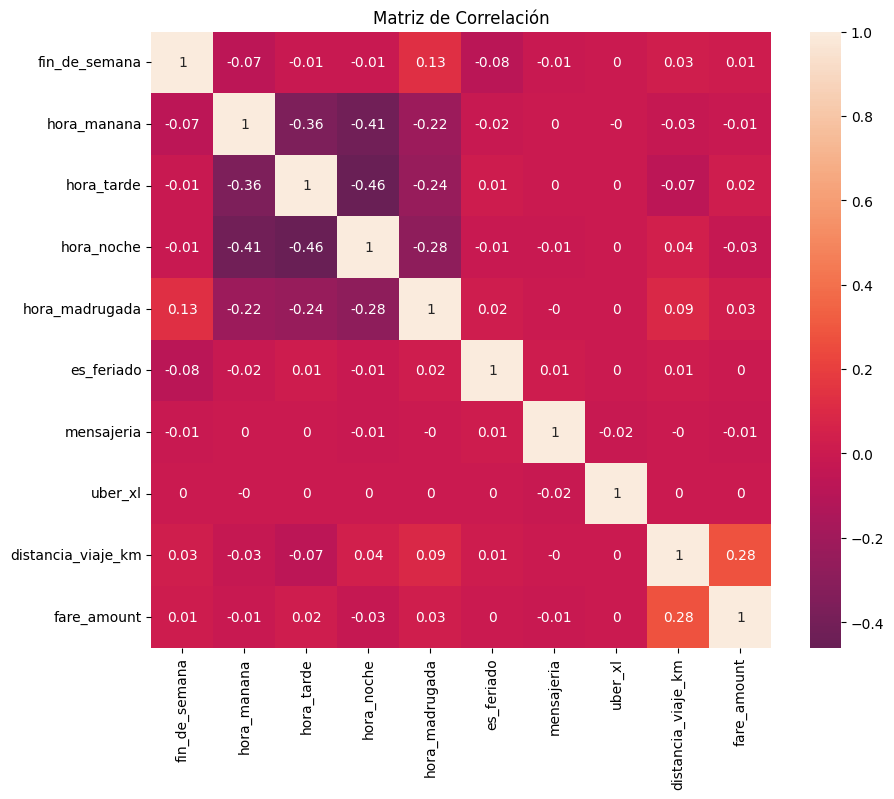

In [26]:
df_correlacion = pd.concat([X_train, y_train], axis=1)
data_correlacion = df_correlacion[['fin_de_semana', 'hora_manana', 'hora_tarde', 'hora_noche','hora_madrugada', 'es_feriado', 'mensajeria', 'uber_xl', 'distancia_viaje_km','fare_amount']].corr().round(2)
plt.figure(figsize=(10, 8))
plt.title('Matriz de Correlación')
sns.heatmap(data_correlacion, annot=True, cmap="rocket", center=0)
plt.show()

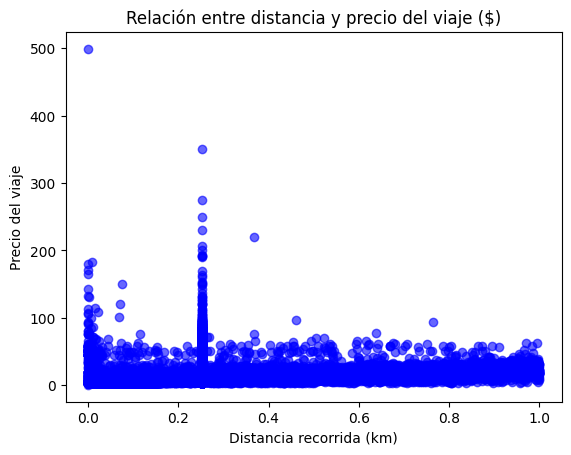

In [27]:
#X_train = X_train[X_train.join(y_train)['fare_amount']<40]
#y_train = y_train[y_train<40]

x = X_train['distancia_viaje_km_escalada']
y = y_train

plt.scatter(x, y, color='blue', alpha=0.6)

plt.xlabel("Distancia recorrida (km)")
plt.ylabel("Precio del viaje")
plt.title("Relación entre distancia y precio del viaje ($)")


plt.show()

In [28]:
#sns.pairplot(X_train.join(y_train),x_vars=X_train.columns,y_vars='fare_amount')
#plt.show()

##LINEAR REGRESION

In [29]:
X_variables = ['fin_de_semana', 'hora_manana', 'hora_tarde', 'hora_noche','hora_madrugada', 'es_feriado', 'mensajeria', 'uber_xl','distancia_viaje_km_escalada']
X_train = X_train[X_variables]
X_test = X_test[X_variables]
X_val = X_val[X_variables]

lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

print('R2 - Train: ', lr.score(X_train,y_train))
print('R2 - Test: ', lr.score(X_test,y_test))


y_pred = lr.predict(X_test)

#MSE
mse_lr = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE): ", mse_lr)

#RMSE
rmse_lr = np.sqrt(mse_lr)
print("Raíz del error cuadrático medio (RMSE): ", rmse_lr)

R2 - Train:  0.07942555577394461
R2 - Test:  0.08408789791277316
Error cuadrático medio (MSE):  88.4386531744776
Raíz del error cuadrático medio (RMSE):  9.404182748887731


Se observa un R2 bajo tanto en train como en test, por ende se puede decir que el modelo no se encuentra sobreajustado. Ademas, al tener un R2 cercano a 0 la capacidad de predecir del modelo es bastante limitada.

##GRADIENTE DESCENDIENTE

In [30]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=1):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W, train_errors, test_errors

In [31]:
X_train_np= X_train.values.reshape(-1, len(X_train.columns))
y_train_np= y_train.values.reshape(-1, 1)
X_val_np= X_val.values.reshape(-1, len(X_val.columns))
y_val_np= y_val.values.reshape(-1, 1)
X_test_np= X_test.values.reshape(-1, len(X_test.columns))
y_test_np= y_test.values.reshape(-1, 1)

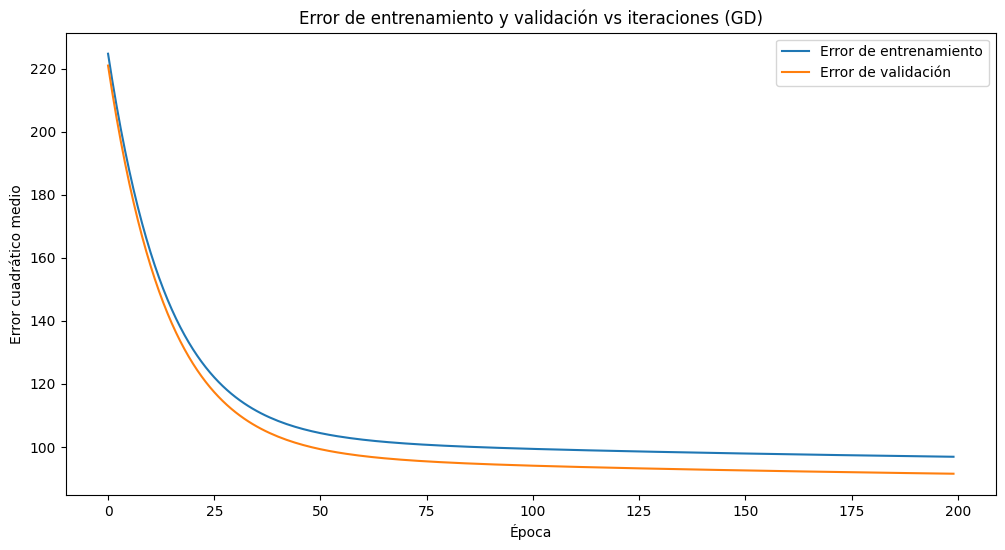

Error cuadrático medio (MSE):  91.48940339476545
Raíz del error cuadrático medio (RMSE):  9.565009325388315


In [32]:
lr_gd = 0.01
epochs_gd = 200

w_valores_gd, train_errors_gd, test_errors_gd = gradient_descent(X_train_np, y_train_np, X_val_np, y_val_np, lr_gd, epochs_gd)
#MSE
mse_gd = test_errors_gd[-1] #Tomo el error de la ultima epoca
print("Error cuadrático medio (MSE): ", mse_gd)

#RMSE
rmse_gd = np.sqrt(mse_gd)
print("Raíz del error cuadrático medio (RMSE): ", rmse_gd)
#print('W: ', w_valores_gd)

Se observa que a medida que aumentan las epocas, el error va disminuyendo hasta tender a 91,14.
El error no mejora en comparacion al modelo de regresion lineal.

##RIDGE

In [33]:
ridge =  RidgeCV(  alphas = np.logspace(-3, 6, 200),
                    fit_intercept   = True,
                    store_cv_results = True
                    #store_cv_values = True
                    )
_ = ridge.fit(X_train, y_train)

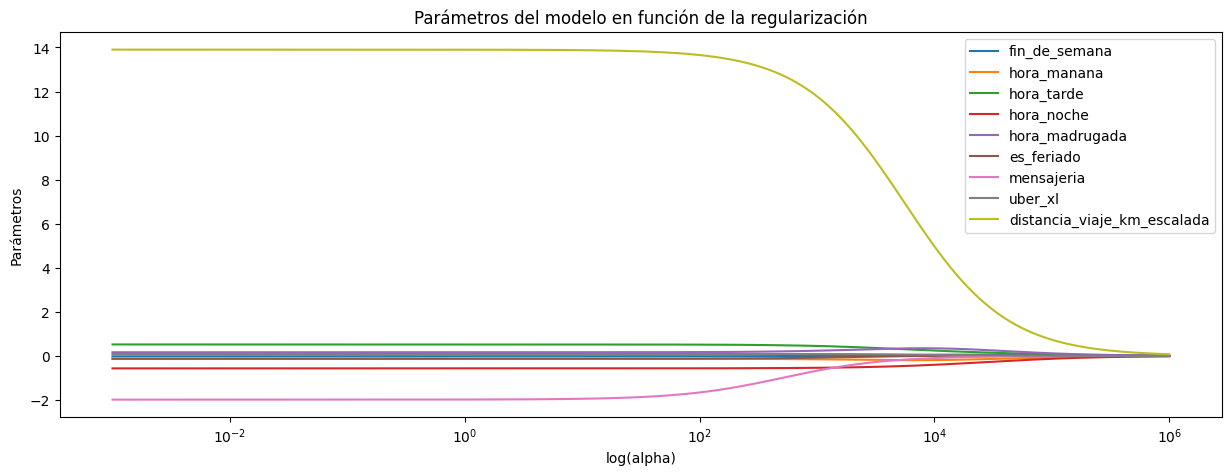

In [34]:
# Evolución de los parámetros en función de alpha

alphas = ridge.alphas
coefs = []

for alpha in alphas:
    modelo_aux = Ridge(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

Se observa como a medida que aumenta el alpha, los parametros van tendiendo a cero. Ademas, se observa un gran peso de la variable distancia_viaje_km_escalada en comparacion con las restantes.

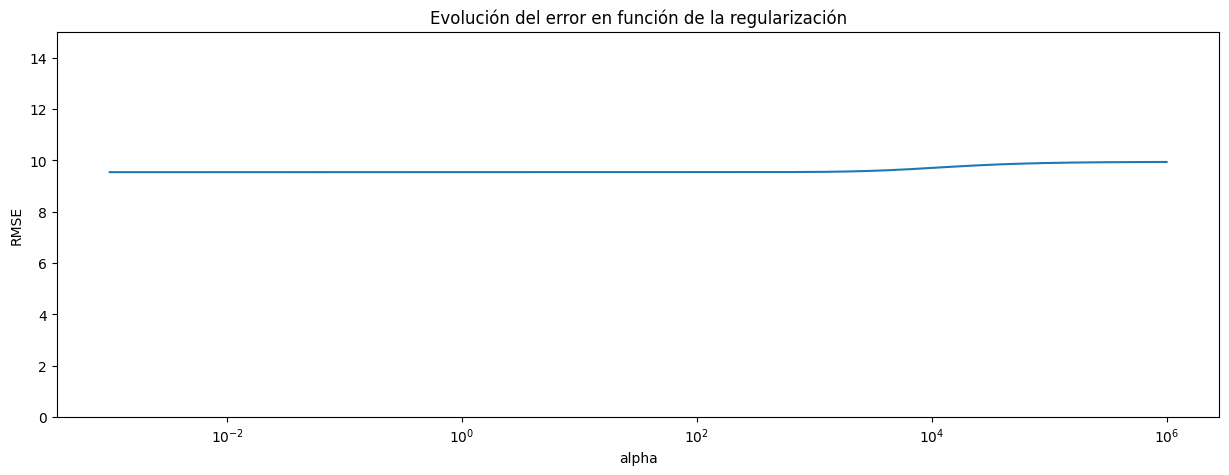

In [35]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mse_cv = ridge.cv_results_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse_ridge     = np.min(rmse_cv)
#optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ridge.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([0,15])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

No se visualiza una mejora del error al aplicar regularizacion

In [36]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {ridge.alpha_}")
print("RMSE: ", min_rmse_ridge)

Mejor valor de alpha encontrado: 3.0367711180354604
RMSE:  9.543532563318921


In [37]:
df_coeficientes_ridge = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': ridge.coef_.flatten()}
                  )

df_coeficientes_ridge[df_coeficientes_ridge.coef != 0]

predictor       coef
0                fin_de_semana  -0.016050
1                  hora_manana  -0.123136
2                   hora_tarde   0.521493
3                   hora_noche  -0.564836
4               hora_madrugada   0.166478
5                   es_feriado  -0.129684
6                   mensajeria  -1.970747
7                      uber_xl   0.090125
8  distancia_viaje_km_escalada  13.894787

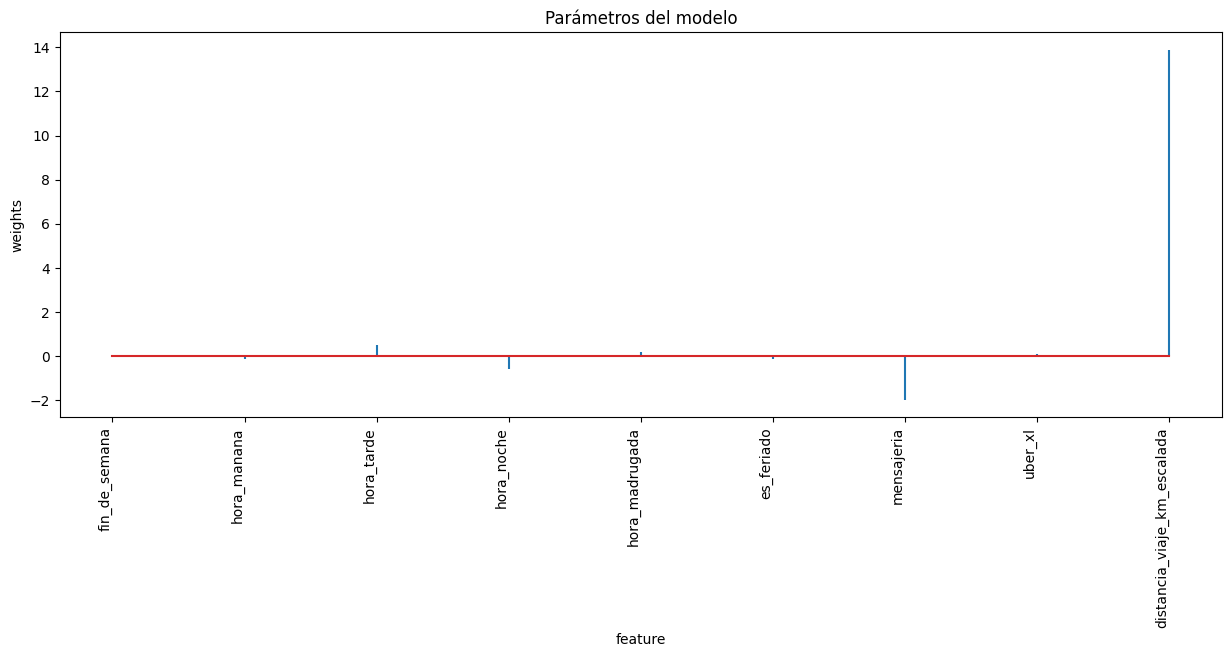

In [38]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_variables,'coef': ridge.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

Se observa una gran diferencia en el valor del parametro de la variable distancia_viaje_km_escalada por sobre las restantes.

##LASSO

In [39]:
#lassoCV = LassoCV()  # alpha controla la fuerza de la regularización L1 (Lasso)

lassoCV = LassoCV(alphas=np.logspace(-3, 6, 200), cv=10)
_ = lassoCV.fit(X_train, y_train)

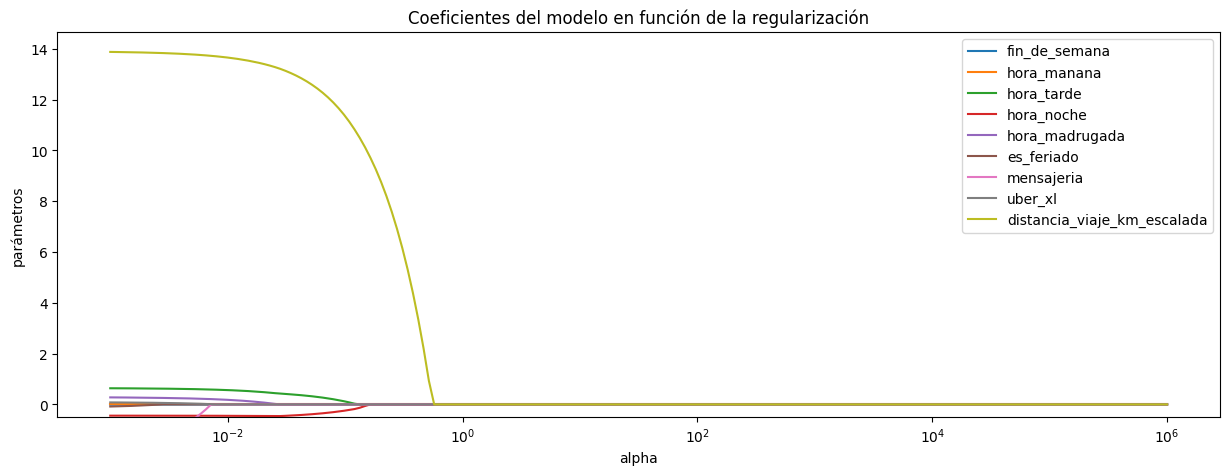

In [40]:
# Evolución de los parámetros en función de alpha

alphas = lassoCV.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Se observa como a medida que aumenta el alpha, los parametros van tendiendo a cero. La tendencia es mucho mas abrupta que en Ridge. Ademas, se observa un gran peso de la variable distancia_viaje_km_escalada en comparacion con las restantes.

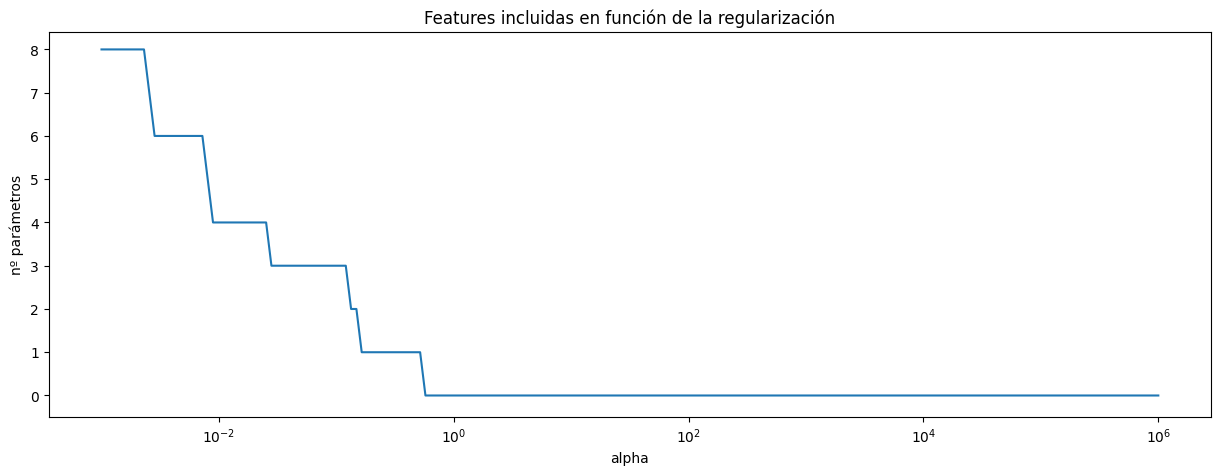

In [41]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = lassoCV.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux =  Lasso(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')
plt.show()

Se puede observar como se van eliminando las variables del modelo (debido a que sus parametros toman valor 0) a medida que va aumentando el alfa. Antes de que alfa sea igual a 10, ya todos los parametros toman valor 0.

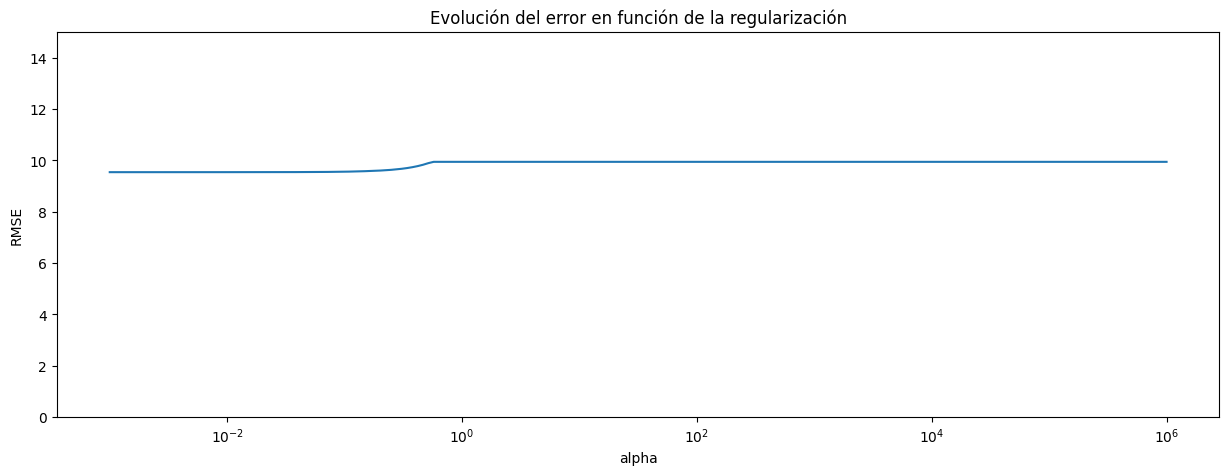

In [42]:
# Evolución del error de validación cruzada en función de alpha

#mse_path almacena el MSE de CV para cada valor de alpha.
mse_cv = lassoCV.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse_lasso     = np.min(rmse_cv)
#optimo       = lassoCV.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lassoCV.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([0,15])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

No se visualiza una mejora significativa en el error al aplicar regularizacion

In [43]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {lassoCV.alpha_}")

Mejor valor de alpha encontrado: 0.001


In [44]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': lassoCV.coef_.flatten()}
                  )

df_coeficientes_lasso[df_coeficientes_lasso.coef != 0]

predictor       coef
0                fin_de_semana  -0.009400
2                   hora_tarde   0.636305
3                   hora_noche  -0.442742
4               hora_madrugada   0.276932
5                   es_feriado  -0.082832
6                   mensajeria  -1.708822
7                      uber_xl   0.079133
8  distancia_viaje_km_escalada  13.877261

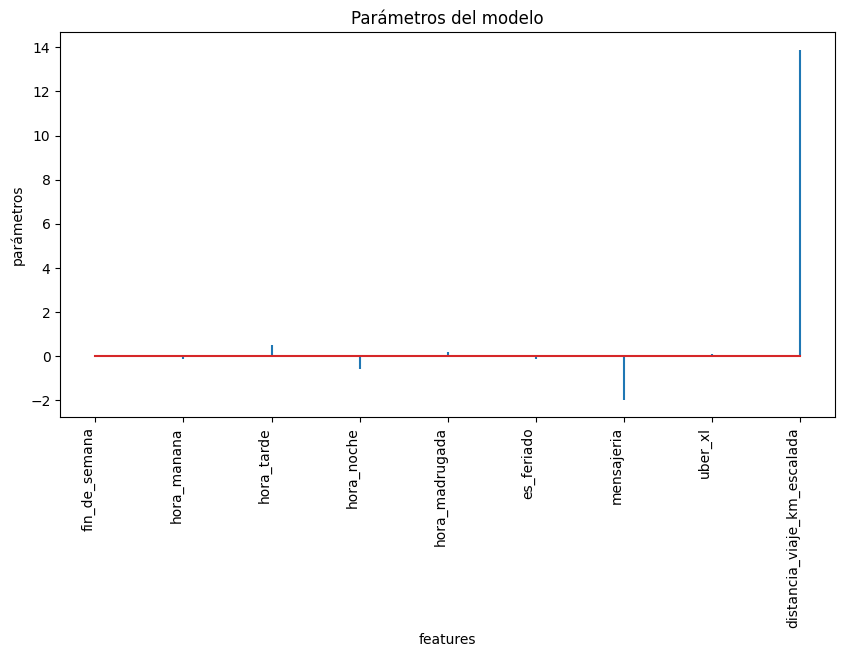

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

Se observa una gran diferencia en el valor del parametro de la variable distancia_viaje_km_escalada por sobre las restantes.

In [46]:
y_pred = lassoCV.predict(X_test)

In [47]:
# Error de test del modelo

mse_lasso = mean_squared_error(y_test,y_pred)
rmse_lasso = np.sqrt(mse_lasso)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 9.404140111716218


In [48]:
R2 = r2_score(y_test, y_pred)
R2

0.08409620311353383

##Comparacion de modelos

In [49]:
np.set_printoptions(suppress=True, precision=4)

print("\nCoeficientes del modelo Linear Regression:")
print(np.round(lr.coef_,2))
print("RMSE: ", rmse_lr)

print("\nCoeficientes del modelo con Gradiente Descendiente:")
print([round(x, 2) for x in w_valores_gd.flatten()])
print("RMSE: ", rmse_gd)
print(f"LR: {lassoCV.alpha_} y Epocas: {epochs_gd}")

print("\nCoeficientes del modelo Lasso:")
print(np.round(lassoCV.coef_,2))
print("RMSE: ", min_rmse_lasso)
print(f"Mejor valor de alpha encontrado: {lassoCV.alpha_}")

print("\nCoeficientes del modelo Ridge:")
print(np.round(ridge.coef_,2))
print("RMSE: ", min_rmse_ridge)
print(f"Mejor valor de alpha encontrado: {ridge.alpha_}")




Coeficientes del modelo Linear Regression:
[-0.02  7.03  7.68  6.59  7.32 -0.13 -1.98  0.09 13.9 ]
RMSE:  9.404182748887731

Coeficientes del modelo con Gradiente Descendiente:
[6.71, 2.32, 2.36, 2.18, 2.03, 1.34, 0.04, -1.49, 0.09, 3.47]
RMSE:  9.565009325388315
LR: 0.001 y Epocas: 200

Coeficientes del modelo Lasso:
[-0.01 -0.    0.64 -0.44  0.28 -0.08 -1.71  0.08 13.88]
RMSE:  9.543529459837528
Mejor valor de alpha encontrado: 0.001

Coeficientes del modelo Ridge:
[-0.02 -0.12  0.52 -0.56  0.17 -0.13 -1.97  0.09 13.89]
RMSE:  9.543532563318921
Mejor valor de alpha encontrado: 3.0367711180354604


##Conclusion

Dado el valor de R2 cercano a 0 tanto en el conjunto de entrenamiento como en el de prueba, se concluye que el modelo no ha logrado un buen ajuste sobre los datos analizados. La casi nula diferencia entre los errores del model pre y post aplicación de técnicas de regularización nos permite concluir que tampoco se han generado mejoras significativas en el desempeño del modelo luego de la aplicacion de Ridge y/o Lasso. Esto podría deberse a la ausencia de variables relevantes en el dataset, a la incapacidad nuestra de detectarlas o a la falta de capacidad del modelo lineal para capturar la complejidad de las relaciones presentes en los datos (es un posible que un modelo con estas caracteristicas no sea el adecuado). Además, se detectaron numerosos valores atípicos en la variable distancia_viaje_km, que resultó ser la más influyente en la predicción (segun se observaba en los graficos de Ridge y Lasso). Es posible que no hayamos podido tratar de manera correcta el ruido presente en los datos, lo que también podría haber afectado la capacidad predictiva del modelo.